## Condensate growth in 2D projected GPE
This notebook gives an example of usage for the 2D projected GPE. 

Starting from a random initial condition, the low energy c-field evolves in the presence of a high energy reservoir able to exchange particles and energy with the c-field. 

In [11]:
using ProjectedGPE;

In [7]:
function timeevolution2()
siminfo = Params()
#== start template ==#
#fundamental constants/units
  ħ = 1.0545718e-34
  kB = 1.38064852e-23
  amu = 1.660339040e-27
  Bohr = 5.29e-11
#Rb87 mass and scattering length
  m = 86.909180527*amu
  as = 100*Bohr
#trap frequencies
  ωx = 2π
  ωy = 4ωx
  ωz = 0.
#choice of time, length, energy units
  t0 = 1.0/ωy
  x0 = sqrt(ħ*t0/m)
  E0 = ħ/t0
#interactions
  #g  = (4*pi*ħ^2*as/m)*x0^3/E0 #dimensionless 3D
  g = 0.1 #test 2D
#damping parameters (dimensionless)
  Γ̄  = 0.05
  M̄  = 0.0
#chemical potential (dimensionless)
  μ  = 12.0
#time evolution parameters
  ti = 0.0
  tf = 1.0/Γ̄  #evolve for 2 damping times
  Nt = 50
  t = collect(linspace(ti,tf,Nt))
  dt = 0.01π/μ #integrate step size [ - should have dt ≪ 2π/μ]
#== end template ==#    
    
@pack siminfo = ωx,ωy,ωz,Γ̄,M̄,g,t0,x0,E0,μ,ti,tf,Nt,t,dt

#Initialize CField (dimensionless)
  basis = "Hermite"
  ecut = 30*ħ*ωy/E0 
  Ω = [ωx; ωy]*t0
  cinfo = makecinfo(basis,ecut,Ω)
  @unpack en,P,M = cinfo ;Mx,My = M
  x,wx,Tx,y,wy,Ty = makealltrans(basis,M,Ω)
  Wxy = wx.*wy'
#test transform
  c0   = randn(Mx,My)+im*randn(Mx,My); c0=P.*c0
  ψ0   = Tx*c0*Ty' #initial condition
  ψ    = Tx*c0*Ty' #a field to write to in place 

#PGPE time evolution
#out of place
function nlin(c)
    ψ = Tx*c*Ty'
    Tx'*(Wxy.*abs.(ψ).^2.*ψ)*Ty
end

#in place
function nlin!(c,dc)
    ψ = Tx*c*Ty'
    dc.= Tx'*(Wxy.*abs.(ψ).^2.*ψ)*Ty
end

#dPGPE in reservoir "frame"
#out of place
function Lgp(t,c)
     P.*(-im*(1-im*Γ̄)*((en - μ).*c .+ g*nlin(c)))
end

#in place
function Lgp!(t,c,dc)
    dc = nlin!(c,dc)
    dc .= P.*(-im*(1-im*Γ̄)*((en - μ).*c .+ g*dc))
end

c0    = P.*(randn(Mx,My) + im*randn(Mx,My)) #create random initial state
tspan = (t[1],t[end])
prob = ODEProblem(Lgp!,c0,tspan)
alg = Tsit5()
#alg =    DP5()
#abstol = 1e-3
#reltol = 1e-3
println("Started evolution ...")
#@time sol = solve(prob,alg,dt=dt,saveat=t,alg_hints=[:stiff],save_everystep=false,dense=false);
@time sol = solve(prob,alg,dt=dt,saveat=t);
println("... Finished.")
return siminfo,cinfo,sol
end


timeevolution2 (generic function with 1 method)

In [8]:
siminfo,cinfo,sol = timeevolution2()

Started evolution ...
 12.864004 seconds (3.62 M allocations: 3.302 GB, 5.13% gc time)
... Finished.


(ProjectedGPE.Params
  ħ: Float64 1.0545718e-34
  kB: Float64 1.38064852e-23
  amu: Float64 1.66033904e-27
  Bohr: Float64 5.29e-11
  m: Float64 1.4429870536338587e-25
  as: Float64 5.29e-9
  ωx: Float64 6.283185307179586
  ωy: Float64 25.132741228718345
  ωz: Float64 0.0
  t0: Float64 0.039788735772973836
  x0: Float64 5.392459968224566e-6
  E0: Float64 2.6504280156503715e-33
  g: Float64 0.1
  Γ̄: Float64 0.05
  M̄: Float64 0.0
  μ: Float64 12.0
  ti: Float64 0.0
  tf: Float64 20.0
  Nt: Int64 50
  t: Array{Float64}((50,)) [0.0,0.408163,0.816327,1.22449,1.63265,2.04082,2.44898,2.85714,3.26531,3.67347  …  16.3265,16.7347,17.1429,17.551,17.9592,18.3673,18.7755,19.1837,19.5918,20.0]
  dt: Float64 0.0026179938779914945
,ProjectedGPE.CInfo
  basis: String "Hermite"
  Ω: Array{Float64}((2,)) [0.25,1.0]
  ecut: Float64 29.999999999999996
  e0: Float64 0.625
  Mmax: Int64 118
  Mult: Int64 1800
  M: Array{Int64}((2,)) [118,30]
  en: Array{Float64}((118,30)) [0.625 1.625 … 28.625 29.625; 0.87

In [9]:
#plot solution for 2D
## Transform to cartesian grid
@unpack ħ,m,ωx,ωy,ωz,Γ̄,M̄,g,x0,t0,E0,μ,ti,tf,Nt,t,dt = siminfo
@unpack M,Ω,ecut,P,en = cinfo; Mx,My = M;

Interact.Options{:SelectionSlider,Int64}(5: "input-2" = 25 Int64 ,"i",25,"25",Interact.OptionDict(DataStructures.OrderedDict("1"=>1,"2"=>2,"3"=>3,"4"=>4,"5"=>5,"6"=>6,"7"=>7,"8"=>8,"9"=>9,"10"=>10…),Dict(2=>"2",11=>"11",39=>"39",46=>"46",25=>"25",42=>"42",29=>"29",8=>"8",20=>"20",14=>"14"…)),Any[],Any[],true,"horizontal")

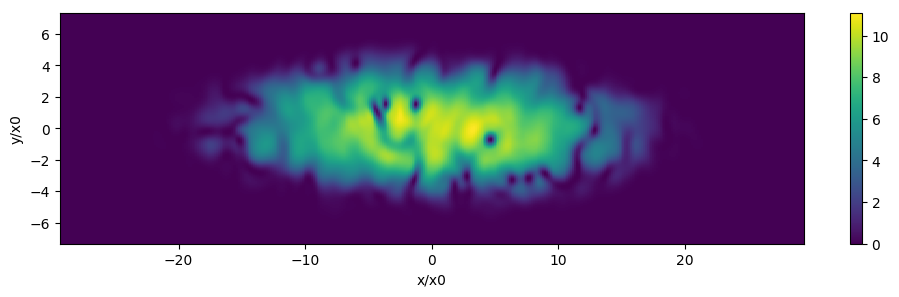

In [10]:
using Interact, PyPlot

#lets be explicit about units:
Rx = sqrt(2μ*E0/m/ωx^2)/x0
Ry = sqrt(2μ*E0/m/ωy^2)/x0
yMax=1.5Ry
xMax=1.5Rx

Nx = 400
Ny = Nx
x = collect(linspace(-xMax,xMax,Nx))
y = collect(linspace(-yMax,yMax,Ny))
Tx = eigmat("Hermite",Mx,x,ωx/ωy)
Ty = eigmat("Hermite",My,y,1); #units of ωy
#θ = unwrap(angle(ψ));

#Plot
f=figure(figsize=(12,3))
@manipulate for i=1:length(t) withfig(f,clear=true) do
    ψ = Tx*sol[i]*Ty';
    pcolormesh(x,y,g*abs(ψ').^2)
    xlabel("x/x0")
    ylabel("y/x0")
    colorbar()
    end
end